In [24]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [25]:
!python --version

Python 3.7.7


In [26]:
pwd

'd:\\Workspace\\Project'

In [27]:
# 네이버에서 검색어 입력받아 검색 한 후 블로그 메뉴를 선택하고
# 오른쪽에 있는 검색옵션 버튼을 눌러서
# 정렬 방식과 기간을 입력하기

#Step 0. 필요한 모듈과 라이브러리를 로딩합니다.
import sys
import os
import pandas as pd
import numpy as np

from bs4 import BeautifulSoup
from selenium import webdriver
import time
import tqdm
from tqdm.notebook import tqdm

In [28]:
query_txt = input('1.크롤링할 키워드는 무엇입니까?: ')
# query_txt2 = input('2.제외할 첫번째 키워드를 입력하세요: ')
# query_txt3 = input('3.제외할 두번째 키워드를 입력하세요: '|)

start_date = input('4.조회를 시작할 날짜를 입력하세요(예:2017-01-01) :')
end_date = input('5.조회를 종료할 날짜를 입력하세요(예:2017-12-31): ')

1.크롤링할 키워드는 무엇입니까?: 
4.조회를 시작할 날짜를 입력하세요(예:2017-01-01) :
5.조회를 종료할 날짜를 입력하세요(예:2017-12-31): 


In [29]:
query_txt="여행"
start_date="20200601"
end_date="20200607"

In [30]:
#Step 1. 크롬 웹브라우저 실행
path = "d:/Workspace/Project/chromedriver.exe"   # 윈도우는 "chromedriver.exe"

driver = webdriver.Chrome(path)
# 사이트 주소는 네이버
driver.get('http://www.naver.com')
time.sleep(2)

#Step 2. 네이버 검색창에 "검색어" 검색
element = driver.find_element_by_id("query")
element.send_keys(query_txt)  # query_txt는 위에서 입력한 '이재용'
element.submit()

#Step 3. "블로그" 카테고리 선택
driver.find_element_by_link_text("블로그").click( )    # .click() 괄호 안을 눌러라는 뜻

#Step 4. 오른쪽의 검색 옵션 버튼 클릭
driver.find_element_by_id("_search_option_btn").click( )

#Step 5. 정렬 : "관련도순" 
# 개발자 도구에서 정렬 버튼의 id 가 보이지 않습니다.
# 이럴 경우 쉽게 사용할 수 있는 방법이 바로 xpath 를 이용하는 방법입니다.
# xpath는 개발자 도구에서 해당 메뉴 부분을 마우스 오른쪽 버튼을 누르고 
# copy -> copy xpath 를 선택하면 됩니다
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/a""").click( )  # 정렬 버튼의 xpath 클릭
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[1]/div/ul/li[1]/a""").click( ) # 관련도순 xpath

#Step 6. 날짜 입력
driver.find_element_by_xpath("""//*[@id="snb"]/div/ul/li[2]/a""").click()
time.sleep(2)

# 이 부분이 아주 중요합니다.
# 날짜 부분에 날짜를 입력할 때 입력 속도가 너무 빠를 경우 날짜가 입력이 되다가 
# 오타가 나오는 경우가 많습니다.
# 그래서 날짜를 입력할 때 for 반복문을 사용해서 1 글자씩 입력하도록 코딩했습니다.

# 시작 날짜 입력하기
s_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""")     
driver.find_element_by_xpath("""//*[@id="blog_input_period_begin"]""").click()
s_date.clear( )  # 날짜 입력 부분에 기존에 입력되어 있던 날짜를 제거합니다. 
time.sleep(1)
# 아래 코드가 날짜를 for 반복문으로 1 글자씩 입력하는 부분입니다.
for c in start_date:
    s_date.send_keys(c)
    time.sleep(0.1)
    
# 종료 날짜 입력하기
e_date = driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""")
driver.find_element_by_xpath("""//*[@id="blog_input_period_end"]""").click()
e_date.clear()
time.sleep(1)

for c in end_date:
    e_date.send_keys(c)
    time.sleep(0.1)
    
# Step7. 날짜 입력 "적용하기" 버튼을 클릭 합니다.  
driver.find_element_by_class_name("tx").click()
time.sleep(3)

# # Step 8. 상세 검색버튼을 클릭 후 제외할 단어들을 설정합니다.
# ele2 = driver.find_element_by_id("inpop3")
# ele2.send_keys(query_txt2)
# ele2.send_keys(',')
# ele2.send_keys(query_txt3)
# driver.find_element_by_css_selector(".btn_ft.ty_green._search").click( )

## 글 url 크롤링 시작

In [31]:
url_list = []
title_list = []

# ★몇개의 페이지를 크롤링할지 선택
total_page = 10
for i in tqdm(range(0, total_page)):  # 페이지 번호
    i = i*10 + 1
    url = "https://search.naver.com/search.naver\
?date_from={0}&date_option=8&date_to={1}\
&dup_remove=1&nso=p%3Afrom{2}to{3}post_blogurl=\
&post_blogurl_without=&query={4}&sm=tab_pge&srchby=all&st=sim&where=post&start={5}".format(start_date,end_date,start_date,end_date,query_txt, i)
    driver.get(url)
    time.sleep(0.5)
    
    # URL 크롤링 시작
    titles = "a.sh_blog_title._sp_each_url._sp_each_title"
    article_raw = driver.find_elements_by_css_selector(titles)
#     article_raw

    # url 크롤링 시작    
    for article in article_raw:
        url = article.get_attribute('href')   
        url_list.append(url)
    
    # 제목 크롤링 시작    
    for article in article_raw:
        title = article.get_attribute('title')   
        title_list.append(title)
    
        print(title)
    
print('url갯수: ', len(url_list))
print('url갯수: ', len(title_list))

df = pd.DataFrame({'url':url_list, 'title':title_list})

# 저장하기
df.to_excel("blog_url.xlsx")

제주 동쪽 여행 사려니숲길, 장미 그리고 일도광해
제주 혼자 여행 섶섬지기 & 소천지
평창 여행 :: 에어비앤비 숙소가 다한 첫 날, 예술인마을
군산 선유도 여행 대장도 대장봉 트레킹
멕시코시티 여행 생각보다 위험하지 않아요
유럽여행준비물, 한글로 된 유럽지도 1+1할 때 챙겨두자!
도쿄 여행 에그타르트 맛집, 나타 데 크리스티아노
경주여행 / 경주 오아시스 글램핑장 펜션 카라반
대만족했던 제주 단체여행
6월에 가기 좋은 제주 여행
강화도 루지  가볼만한곳 1위 된 한국의 스위스여행!
골프여행 강원도 델피노 CC, 울산바위 뷰 라운딩 찐 힐링~
제주 우도 여행 1박2일로 즐긴 또 다른 매력의 섬
아고다 6월 할인코드 알려드려욤 & 베트남 호이안 여행 괜찮은곳들
태국 방콕 여행 중 하루는 반드시 왓아룬 사원에 가세요
여수 여행 일출전망대 와 오동도
제주도 여행 3박4일 프롤로그
나홀로 제주, 2박 3일 제주여행
남해 아난티 그랜드빌라 2박3일 가족여행
혼자 동남아 말레이시아 여행 (Kuala Lumpur, Malaysia)
여행앨범 만들기! 포토프린터 캐논셀피로 만들어보세요~
춘천 1박2일 글램핑여행
경주 여행코스 칼국수 매니아가 발견한 곳
6월 제주도 2박3일 여행코스 (우도 포함) - 2일차 계획
호이안 여행 코코넛배  살짝 무섭지만 신나는 뱃놀이
프랑스여행 파리 생샤펠성당 113
타카오1972 대만훠궈 해외여행 언제쯤
제주여행 수국이 있는 제주도 카멜리아힐
군산 여행코스, 신흥동 일본식가옥(구 히로쓰가옥)
04_제주도, 하이킹과 여행 마무리
스페인 세비야여행, 이른 아침의 스페인광장
삼척 여행) 삼척 번개시장, 어머님이 동해로 여행 가자고 하는 이유
제주 여행 더울땐 아쿠아플라넷, 체험은 필수~
국내기차여행?! 국내여행 할 때 참고해야 할 관광열차 소개.
일본 가고시마 여행 화산 분출 활발한 사쿠라지마 가볼만한 곳
제주도 2박3일 여행코스 국룰♥
하동펜션 알프스동화펜션 가족여행
수영의 골목골목 여행 " 취향道(도) 수영口(구) "
경주 여행 양남 주상절리 

# 글 크롤링하기

In [32]:
import sys
import os
import pandas as pd
import numpy as np

In [35]:
# "url_list.csv" 불러오기
url_load = pd.read_excel("blog_url.xlsx")        # 기본 모델

num_list = len(url_load)

print(num_list)
url_load

100


,Unnamed: 0,url,title
0,0,https://blog.naver.com/kci_kci?Redirect=Log&lo...,"제주 동쪽 여행 사려니숲길, 장미 그리고 일도광해"
1,1,https://blog.naver.com/chanhee008?Redirect=Log...,제주 혼자 여행 섶섬지기 & 소천지
2,2,https://blog.naver.com/vov14vov?Redirect=Log&l...,"평창 여행 :: 에어비앤비 숙소가 다한 첫 날, 예술인마을"
3,3,https://blog.naver.com/nivearein?Redirect=Log&...,군산 선유도 여행 대장도 대장봉 트레킹
4,4,https://blog.naver.com/csn324?Redirect=Log&log...,멕시코시티 여행 생각보다 위험하지 않아요
...,...,...,...
95,95,http://stuffkorea.blogspot.com/2020/06/1.html,제주도 드론 여행 1일차
96,96,https://qubix.tistory.com/2048,[말레이시아 코타키나발루 여행] 키나발루 산 전망대
97,97,http://blog.daum.net/ojyouk/8493102,[태안여행]안면암(2020.05.27.)
98,98,https://walkview.tistory.com/5734,여수여행 필수 쇼핑 목록 밥도둑 여수 돌산 갓김치 김수덕명가


In [36]:
dict = {}  # 전체 크롤링 데이터를 담을 그릇

# ★수집할 글 갯수
number = 100
for i in tqdm(range(0, number)): 
    # 글 띄우기
    url = url_load['url'][i]
    driver = webdriver.Chrome("d:/Workspace/Project/chromedriver.exe")
    driver.get(url)   # 글 띄우기
    
    # 크롤링
    
    try : 
        # iframe 접근
        driver.switch_to_frame('mainFrame')

        target_info = {}

        # 제목 크롤링 시작
        overlays = ".se-fs-.se-ff-"                                 
        tit = driver.find_element_by_css_selector(overlays)         # title
        title = tit.text
        title

        # 글쓴이 크롤링 시작
        overlays = ".nick"                                 
        nick = driver.find_element_by_css_selector(overlays)         # nick
        nickname = nick.text

        # 날짜 크롤링
        overlays = ".se_publishDate.pcol2"                                 
        date = driver.find_element_by_css_selector(overlays)         # date
        datetime = date.text

        # 내용 크롤링
        overlays = ".se-component.se-text.se-l-default"                                 
        contents = driver.find_elements_by_css_selector(overlays)         # date

        content_list = []
        for content in contents:
            content_list.append(content.text)

        content_str = ' '.join(content_list)

        # 글 하나는 target_info라는 딕셔너리에 담기게 되고,
        target_info['title'] = title
        target_info['nickname'] = nickname
        target_info['datetime'] = datetime
        target_info['content'] = content_str

        # 각각의 글은 dict라는 딕셔너리에 담기게 됩니다.
        dict[i] = target_info
        time.sleep(1)
        
        print(i, title)

        # 글 하나 크롤링 후 크롬 창 닫기
        driver.close()       
    
    # 에러나면 현재 크롬창 닫고 다음 글(i+1)로 이동
    except:
        driver.close()
        time.sleep(1)
        continue
    
    # 중간,중간에 파일로 저장하기
    if i == 30 or 50 or 80:
        # 판다스로 만들기
        import pandas as pd
        result_df = pd.DataFrame.from_dict(dict, 'index')

        # 저장하기
        result_df.to_excel("blog_content_이재용심사전.xlsx")
        time.sleep(3)

print('수집한 글 갯수: ', len(dict))
print(dict)

# 판다스로 만들기
import pandas as pd
result_df = pd.DataFrame.from_dict(dict, 'index')

# 저장하기
result_df.to_excel("blog_content_이재용심사전.xlsx")

C:\ProgramData\Anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: use driver.switch_to.frame instead
  from ipykernel import kernelapp as app


0 한 달 전 예약해 두었던 제주 여행 스케쥴을 꼼꼼하게 만들었는데 피톤치드 가득한 사려니숲길과 장미도 보고 싶어 제주 동쪽 여행을 계획했거든요!
1 제주 혼자 여행 섶섬지기 & 소천지
3 군산에서는 버스 타고 섬 여행을 할 수 있다? 네 맞습니다. 2016년 신시도와 무녀도를 잇는 고군산대교가 개통되고, 2017년에 장자대교와 선유대교가 동시 개통되면서 시내버스를 이용하여 고군산군도를 누빌 수 있게 됐습니다. 접근성이 좋아진 만큼 군산 선유도 여행은 군산을 대표하는 관광지가 됐습니다.
4 멕시코시티 여행 생각보다 위험하지 않아요
5 유럽여행준비물, 한글로 된 유럽지도 1+1할 때 챙겨두자!
6 도쿄 여행 에그타르트 맛집, 나타 데 크리스티아노
7 경주여행 / 경주 오아시스 글램핑장 펜션 카라반 
8 대만족했던 제주 단체여행
10 강화도 루지 🎠 가볼만한곳 1위 된 한국의 스위스여행!
11 골프여행 강원도 델피노 CC, 울산바위 뷰 라운딩 찐 힐링~
12 제주 우도 여행 1박2일로 즐긴 또 다른 매력의 섬
13 아고다 6월 할인코드 알려드려욤 & 베트남 호이안 여행 괜찮은곳들
14 아니, 고작 한 시간 있다 와놓고선 무슨 하루를 투자해?
15 여수 여행 일출전망대 와 오동도
17 
20 여행앨범 만들기! 포토프린터 캐논셀피로 만들어보세요~
23 6월 제주도 2박3일 여행코스 (우도 포함) - 2일차 계획
24 호이안 여행 코코넛배  살짝 무섭지만 신나는 뱃놀이
25 
26 타카오1972 대만훠궈 해외여행 언제쯤
27 
28 군산 여행코스, 신흥동 일본식가옥
29 
30 아침 일찍 가니 그나마 한적한 풍경 ♡
31 삼척 여행) 삼척 번개시장, 어머님이 동해로 여행 가자고 하는 이유
32 제주 여행 더울땐 아쿠아플라넷, 체험은 필수~
34 
35 
36 하동펜션 알프스동화펜션 가족여행
37 취향道(도) 수영口(구)
38 경주 여행 양남 주상절리 파도소리길 걷다
39 여행은 낯선 곳에 갈 때, 더 즐거운 법
40 춘천여행 구봉산 산토리니 카페 사진 찍기 예쁜 카페


## 내용 텍스트 분석

In [13]:
# !pip install graphviz
# !pip install konlpy

import scipy as sp
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# 그래프
%matplotlib inline
import os
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
                                        # 맥 os:  
rc('font', family=font_name)

# 워닝 없애주는 것
import warnings  
warnings.filterwarnings('ignore')

In [8]:
from konlpy.tag import Kkma       ; kkma = Kkma()
from konlpy.tag import Hannanum   ; hannanum = Hannanum()
from konlpy.tag import Okt        ; t = Okt()
from konlpy.tag import *
import pickle

In [14]:
df_r = pd.read_excel("blog_content_이재용심사전.xlsx")
df_r

,title,nickname,datetime,content
3,삼성 이재용 부회장의 구속영장 청구를 보고...,북극성,2020. 6. 4. 13:38,삼성의 이재용 부회장에게 구속영장이 청구되었습니다. 많은 생각을 하게 되는데요....
4,이재용 삼성전자 부회장에 대한 구속영장 청구라? 검찰도 두 갈래. 한쪽은 우국파 다...,ST,2020. 6. 4. 16:07,"삼성전자 이재용 부회장이 무슨 호구인가?\n걸핏하면 구속영장 청구, 걸핏하면 해외순..."
5,삼성 이재용 다시 구속 위기,안양천변\n(emfrkd65),2020. 6. 5. 7:06,삼성 이재용 부회장 등 관련된 미래전략실 최지성 등 3명이\n검찰에 의해 구속영장이...
6,삼성전자 이재용 부회장 영장청구...,Humblelife,2020. 6. 6. 13:28,삼성전자 이재용 부회장이 아버지 이건희의 재산 상속문제로 인해 야기된 여러가지 이유...
7,NaN,김태훈,2020. 6. 4. 12:52,안녕하세요\n1년 6개월 간 삼성물산 제일모직 합병 의혹 등을 수사해온 검찰이 이재...
8,보수우파 기독교인은 이재용 사건을 어떻게 바라봐야 하나,믿음방패,2020. 6. 4. 19:05,기독교인은 이념 때문에 정의를 왜곡해선 안된다.\n이재용에 대해서 정직하게 판단하자...
10,이재용 구속 허경영 일침 & 21세기는 허경영 시대다!,불루오션,2020. 6. 7. 19:44,이재용 구속\n허경영 일침\n & 21세기는 허경영 시대다!
11,뉴스에서 악재를 너무 자주 내보내면 ? 삼성전자 이재용부회장 구속.. 팔아야하나??,탑엔드,2020. 6. 5. 8:20,안녕하세요 탑엔드입니다.\n http://naver.me/FIrrvgWo 요즘 이...
12,이재용 구속 영장 청구 - 항상 숨겨진 그림을 잘 찾아내고 이해해야 합니다.,Sammy,2020. 6. 4. 17:15,오늘 이런 뉴스가 있네요.\n삼성전자 이재용 부회장 참 인생 사는 것이 힘듭니다.\...
14,삼성의 이재용 구속 심사,꿈마을,2020. 6. 5. 1:34,삼성의 이재용 구속 심사한다는 뉴스를 본다.\n우리나라 대표기업인 삼성이 흔들릴까 ...


In [15]:
df_r['content']

3      삼성의 이재용 부회장에게 구속영장이 청구되었습니다.  많은 생각을 하게 되는데요....
4     삼성전자 이재용 부회장이 무슨 호구인가?\n걸핏하면 구속영장 청구, 걸핏하면 해외순...
5     삼성 이재용 부회장 등 관련된 미래전략실 최지성 등 3명이\n검찰에 의해 구속영장이...
6     삼성전자 이재용 부회장이 아버지 이건희의 재산 상속문제로 인해 야기된 여러가지 이유...
7     안녕하세요\n1년 6개월 간 삼성물산 제일모직 합병 의혹 등을 수사해온 검찰이 이재...
8     기독교인은 이념 때문에 정의를 왜곡해선 안된다.\n이재용에 대해서 정직하게 판단하자...
10                   이재용 구속\n허경영 일침\n & 21세기는 허경영 시대다! 
11     안녕하세요 탑엔드입니다.\n http://naver.me/FIrrvgWo 요즘 이...
12    오늘 이런 뉴스가 있네요.\n삼성전자 이재용 부회장 참 인생 사는 것이 힘듭니다.\...
14    삼성의 이재용 구속 심사한다는 뉴스를 본다.\n우리나라 대표기업인 삼성이 흔들릴까 ...
15    [중앙뉴스=박효영 기자] 이재용 삼성전자 부회장이 연일 실형을 면하기 위한 사회적 ...
16                                                  NaN
17    [브리핑] 김종철 대변인, 이재용 부회장 구속영장 청구 관련\n검찰이 오늘 이재용 ...
18    이재용에게 구속영장이 청구되자 '유감'이라고 했답니다.\nhttps://news.n...
19    #변호인단, #영장청구에 입장문 발표\n"수사심의위 신청하자 영장 청구해"\n"#검...
20    안녕하세요\n삼성은 6일 이재용 부회장이 직접 승계작업을 보고받았다는 일부 언론 보...
21    2020.06.04(목) 세계일보 사회part\n이재용 ‘억울한 이야기 좀 들어달라...
22    분식회계 및 시세조종 혐의로 영장 청구. 최지성과 김종중 등 3명 함께  \

In [16]:
content_list = df_r.content.values.tolist()

print(len(content_list))
content_list

69


[' 삼성의 이재용 부회장에게 구속영장이 청구되었습니다.  많은 생각을 하게 되는데요. 일단 한국의 경제를 봐서는 안타까운 일이 자명합니다. 하지만 이 부회장도 삼성의 합병 및 회계에서 자기는 전혀 보고 받은 바가 없다고 하는 것도 어불성설입니다. 그렇다면 부하 직원들이 독단적으로 회사간의 합병을 결정하고 그리했다는 것인데, 전혀 몰랐다는 것은 상식적이지도 않고, 다른 말로 삼성의 내부 통제가 무너졌다는 것인데 그 역시 문제가 되겠지요.\n오너 일가의 경영과 전문 경영인 체제의 경영 모두 장.단점이 있습니다. 저는 그래도 오너의 경영을 지지하는 편인데, 궁극적으로는 책임감이 더 강하다고 생각하기 때문입니다. 예전에 저희 선배 분 한 분이 CEO로 가셨는데, 어차피 자기 회사가 아니고 자기는 지나가는 사람이라 생각해서 그런지 회사는 적자를 보고 어려워도 자기 연봉은 다 챙기는 것을 보고 많은 생각을 했었지요. \n물론 오너의 전횡등이 문제가 되고 큰 단점이 많기는 한데, 여하튼 저는 그래도 오너의 경영이 최선은 아니라 하더라도 차악은 된다고 생각합니다. 그런면에선 이재용 부회장의 구속이 안타깝게 생각되는 측면도 있습니다. \n저는 문과 출신이고 재계에 몸 담고 있지도 않지만 간접적인 체험으로 이야기를 많이 듣는 편인데요. 정말 기업도 돈 벌기 힘듭니다. 게다가 지금은 우리가 인지하지 못하고 있어도 엄청나게 산업구조가 개편되고 있는 시기입니다. 특히 AI등으로 대표되는 4차산업 혁명의 시기인데요. 기차의 등장으로 마차를 모는 마부의 일 자리가 사라지고, 자동차의 등장으로 인력꾼의 가치가 없어진다 하여도 도도한 시대의 흐름을 피할 수는 없겠지요. \n결국 흐르는 물을 막아서 역류 시킬 수는 없으니, 시대의 흐름에 따르고 우리가 오히려 시장을 선도해야 할 것인데, 계층간의 갈등 등으로 그 마저도 녹록치 않으니 참 안타까운 노릇이라 하겠습니다. \n여하튼 이재용 부회장의 뉴스를 보니, 사람은 평범하게 사는 것이 최고구나하는 생각도 듭니다. 아무리 돈이 많은 삼성의 총수

In [17]:
import nltk
from konlpy.tag import Okt; t = Okt()

In [18]:
# 리스트 중 str 타입이 아닌 요소들이 존재함을 확인
for i in content_list:
    if type(i) == float:
        i = str(i)
        print(i)

nan
nan
nan
nan
nan


In [19]:
# str 타입이 아닌 요소들이 있으면 전부 str 타입으로 바꿔라!
for i in range(len(content_list)):
    if type(content_list[i]) != str:
        content_list[i] = str(content_list[i])

In [20]:
content_text = ''

for each_line in content_list[:2000]:
    content_text = content_text + each_line + '\n'

In [21]:
content_text

' 삼성의 이재용 부회장에게 구속영장이 청구되었습니다.  많은 생각을 하게 되는데요. 일단 한국의 경제를 봐서는 안타까운 일이 자명합니다. 하지만 이 부회장도 삼성의 합병 및 회계에서 자기는 전혀 보고 받은 바가 없다고 하는 것도 어불성설입니다. 그렇다면 부하 직원들이 독단적으로 회사간의 합병을 결정하고 그리했다는 것인데, 전혀 몰랐다는 것은 상식적이지도 않고, 다른 말로 삼성의 내부 통제가 무너졌다는 것인데 그 역시 문제가 되겠지요.\n오너 일가의 경영과 전문 경영인 체제의 경영 모두 장.단점이 있습니다. 저는 그래도 오너의 경영을 지지하는 편인데, 궁극적으로는 책임감이 더 강하다고 생각하기 때문입니다. 예전에 저희 선배 분 한 분이 CEO로 가셨는데, 어차피 자기 회사가 아니고 자기는 지나가는 사람이라 생각해서 그런지 회사는 적자를 보고 어려워도 자기 연봉은 다 챙기는 것을 보고 많은 생각을 했었지요. \n물론 오너의 전횡등이 문제가 되고 큰 단점이 많기는 한데, 여하튼 저는 그래도 오너의 경영이 최선은 아니라 하더라도 차악은 된다고 생각합니다. 그런면에선 이재용 부회장의 구속이 안타깝게 생각되는 측면도 있습니다. \n저는 문과 출신이고 재계에 몸 담고 있지도 않지만 간접적인 체험으로 이야기를 많이 듣는 편인데요. 정말 기업도 돈 벌기 힘듭니다. 게다가 지금은 우리가 인지하지 못하고 있어도 엄청나게 산업구조가 개편되고 있는 시기입니다. 특히 AI등으로 대표되는 4차산업 혁명의 시기인데요. 기차의 등장으로 마차를 모는 마부의 일 자리가 사라지고, 자동차의 등장으로 인력꾼의 가치가 없어진다 하여도 도도한 시대의 흐름을 피할 수는 없겠지요. \n결국 흐르는 물을 막아서 역류 시킬 수는 없으니, 시대의 흐름에 따르고 우리가 오히려 시장을 선도해야 할 것인데, 계층간의 갈등 등으로 그 마저도 녹록치 않으니 참 안타까운 노릇이라 하겠습니다. \n여하튼 이재용 부회장의 뉴스를 보니, 사람은 평범하게 사는 것이 최고구나하는 생각도 듭니다. 아무리 돈이 많은 삼성의 총수라

## 형태소분석을 마친 단어로 만든 token_ko

In [22]:
tokens_ko = t.morphs(content_text)
tokens_ko

['삼성',
 '의',
 '이재용',
 '부회장',
 '에게',
 '구속영장',
 '이',
 '청구',
 '되었습니다',
 '.',
 '많은',
 '생각',
 '을',
 '하게',
 '되는데요',
 '.',
 '일단',
 '한국',
 '의',
 '경제',
 '를',
 '봐',
 '서는',
 '안타까운',
 '일이',
 '자명합니다',
 '.',
 '하지만',
 '이',
 '부회장',
 '도',
 '삼성',
 '의',
 '합병',
 '및',
 '회계',
 '에서',
 '자기',
 '는',
 '전혀',
 '보고',
 '받은',
 '바',
 '가',
 '없다고',
 '하는',
 '것',
 '도',
 '어',
 '불성',
 '설',
 '입니다',
 '.',
 '그렇다면',
 '부하',
 '직원',
 '들',
 '이',
 '독단',
 '적',
 '으로',
 '회사',
 '간',
 '의',
 '합병',
 '을',
 '결정',
 '하고',
 '그리',
 '했다는',
 '것',
 '인데',
 ',',
 '전혀',
 '몰랐다는',
 '것',
 '은',
 '상식',
 '적',
 '이',
 '지도',
 '않고',
 ',',
 '다른',
 '말로',
 '삼성',
 '의',
 '내부',
 '통제',
 '가',
 '무너졌다는',
 '것',
 '인데',
 '그',
 '역시',
 '문제',
 '가',
 '되겠지요',
 '.',
 '\n',
 '오',
 '너',
 '일가',
 '의',
 '경영',
 '과',
 '전문',
 '경영인',
 '체제',
 '의',
 '경영',
 '모두',
 '장',
 '.',
 '단점',
 '이',
 '있습니다',
 '.',
 '저',
 '는',
 '그래도',
 '오',
 '너',
 '의',
 '경영',
 '을',
 '지지',
 '하는',
 '편',
 '인데',
 ',',
 '궁극',
 '적',
 '으로는',
 '책임감',
 '이',
 '더',
 '강하다고',
 '생각',
 '하기',
 '때문',
 '입니다',
 '.',
 '예전',
 '에',
 '저희',
 '선

In [23]:
ko = nltk.Text(tokens_ko)   
print(len(ko.tokens))          # 토큰 전체 갯수
print(len(set(ko.tokens)))     # 토큰 unique 갯수

27130
5303


In [24]:
ko = nltk.Text(tokens_ko)
ko.vocab().most_common(100)    # 가장 많이 나온 단어 100개

[('\n', 1011),
 ('.', 775),
 ('이', 745),
 ('을', 652),
 (',', 516),
 ('의', 502),
 ('에', 442),
 ('를', 385),
 ('은', 371),
 ('삼성', 320),
 ('가', 265),
 ('것', 238),
 ('이재용', 233),
 ('는', 209),
 ('부회장', 207),
 ('한', 198),
 ('들', 190),
 ('으로', 184),
 ('로', 165),
 ('검찰', 157),
 ("'", 140),
 ('도', 138),
 ('성', 137),
 ('적', 136),
 ('에서', 126),
 ('과', 124),
 ('삼', 120),
 ('수', 119),
 ('하는', 110),
 ('수사', 110),
 ('청구', 104),
 ('..', 103),
 ('하고', 101),
 ('(', 100),
 ('등', 99),
 ('구속영장', 98),
 (')', 92),
 ('"', 92),
 ('이다', 90),
 ('전', 90),
 ('인', 85),
 ('할', 84),
 ('바이오', 83),
 ('지', 82),
 ('그', 78),
 ('합병', 77),
 ('경영', 74),
 ('심의', 74),
 ('제일모직', 73),
 ('했다', 73),
 ('전자', 71),
 ('와', 71),
 ('...', 69),
 ('고', 68),
 ('위', 67),
 ('회사', 63),
 ('있는', 63),
 ('해', 61),
 ('\n ', 60),
 ('물산', 59),
 ('다', 53),
 ('대해', 53),
 ('에게', 51),
 ('생각', 51),
 ('기업', 51),
 ('된', 50),
 ('권', 50),
 ('입니다', 49),
 ('있다', 49),
 ('위원회', 48),
 ('서', 47),
 ('승계', 47),
 ('혐의', 47),
 ('사실', 47),
 ('중', 46),
 ('중앙', 46),
 ('의혹

In [33]:
# 불용어 : 인터넷 검색 시 검색 용어로 사용하지 않는 단어. 관사, 전치사, 조사, 접속사 등 검색 색인 단어로 의미가 없는 단어
stop_words = [')','?','1','"(', '_', ')/','\n','.',',', '<','!','(','(', '??','..', '4', '|', '>', '?(', '"…', '#', '&', '・', "']",'.',' ','/',"'",'’','”','“','·', '[','!','\n','·','‘','"','\n ',']',':','…',')','(','-', 'nan','가','요','답변','...','을','수','에','질문','제','를','이','도',
                      '좋','1','는','로','으로','2','것','은','다',',','니다','대','들',
                      '2017','들','데','..','의','때','겠','고','게','네요','한','일','할',
                      '10','?','하는','06','주','려고','인데','거','좀','는데','~','ㅎㅎ',
                      '하나','이상','20','뭐','까','있는','잘','습니다','다면','했','주려',
                      '지','있','못','후','중','줄','6','과','어떤','기본','!!',
                      '단어','라고','중요한','합','가요','....','보이','네','무지','했습니다',
              '이다','대해','에게','입니다','있다','사람','대한','3','합니다','및','장','에서','하고','검','한다','만',
             '적', '성', '삼', '등', '전', '인', '그', '했다', '와', '위', '해', '권', '된', '서', '말', '분']

tokens_ko = [each_word for each_word in tokens_ko
             if each_word not in stop_words]

ko = nltk.Text(tokens_ko)
ko.vocab().most_common(50)

[('삼성', 320),
 ('이재용', 233),
 ('부회장', 207),
 ('검찰', 157),
 ('수사', 110),
 ('청구', 104),
 ('구속영장', 98),
 ('바이오', 83),
 ('합병', 77),
 ('경영', 74),
 ('심의', 74),
 ('제일모직', 73),
 ('전자', 71),
 ('회사', 63),
 ('물산', 59),
 ('생각', 51),
 ('기업', 51),
 ('위원회', 48),
 ('승계', 47),
 ('혐의', 47),
 ('사실', 47),
 ('중앙', 46),
 ('의혹', 46),
 ('구속', 45),
 ('판단', 44),
 ('그룹', 43),
 ('법', 42),
 ('브랜드', 42),
 ('영장', 40),
 ('전략', 36),
 ('까지', 36),
 ('국민', 36),
 ('위해', 35),
 ('회계', 34),
 ('관련', 34),
 ('회장', 33),
 ('직스', 32),
 ('위반', 32),
 ('가치', 30),
 ('경제', 29),
 ('보고', 29),
 ('때문', 29),
 ('미래', 29),
 ('주식', 29),
 ('우리', 28),
 ('뉴스', 28),
 ('신청', 28),
 ('사건', 28),
 ('팀', 28),
 ('지수', 28)]

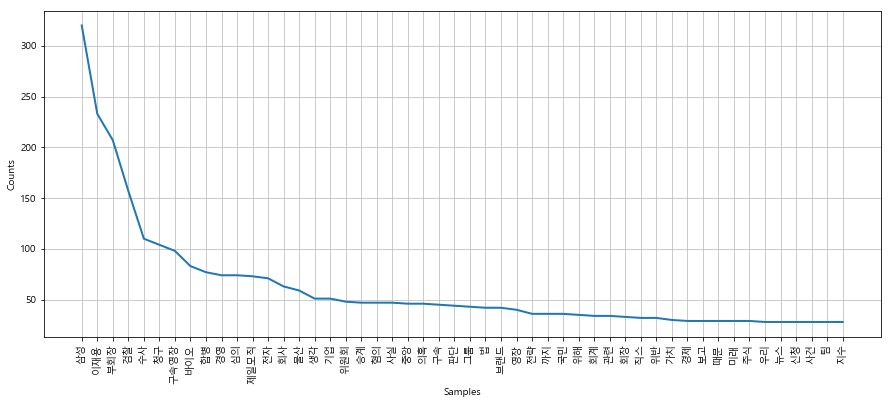

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz             
from sklearn.tree import export_graphviz
plt.figure(figsize=(15,6))
ko.plot(50) 
plt.show()

# 그래프에서 한글 폰트 깨지는 문제에 대한 대처(전역 글꼴 설정)
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
rc('font', family=font_name)

In [35]:
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [36]:
data = ko.vocab().most_common(300)

print(len(data))
data

300


[('삼성', 320),
 ('이재용', 233),
 ('부회장', 207),
 ('검찰', 157),
 ('수사', 110),
 ('청구', 104),
 ('구속영장', 98),
 ('바이오', 83),
 ('합병', 77),
 ('경영', 74),
 ('심의', 74),
 ('제일모직', 73),
 ('전자', 71),
 ('회사', 63),
 ('물산', 59),
 ('생각', 51),
 ('기업', 51),
 ('위원회', 48),
 ('승계', 47),
 ('혐의', 47),
 ('사실', 47),
 ('중앙', 46),
 ('의혹', 46),
 ('구속', 45),
 ('판단', 44),
 ('그룹', 43),
 ('법', 42),
 ('브랜드', 42),
 ('영장', 40),
 ('전략', 36),
 ('까지', 36),
 ('국민', 36),
 ('위해', 35),
 ('회계', 34),
 ('관련', 34),
 ('회장', 33),
 ('직스', 32),
 ('위반', 32),
 ('가치', 30),
 ('경제', 29),
 ('보고', 29),
 ('때문', 29),
 ('미래', 29),
 ('주식', 29),
 ('우리', 28),
 ('뉴스', 28),
 ('신청', 28),
 ('사건', 28),
 ('팀', 28),
 ('지수', 28),
 ('더', 27),
 ('하지', 27),
 ('평판', 26),
 ('있습니다', 25),
 ('저', 25),
 ('명', 25),
 ('사', 25),
 ('나', 25),
 ('이건희', 25),
 ('형', 25),
 ('한국', 24),
 ('투자', 24),
 ('분식회계', 24),
 ('입장', 24),
 ('피스', 24),
 ('오늘', 24),
 ('큰', 23),
 ('부터', 23),
 ('2015년', 23),
 ('상', 23),
 ('분석', 23),
 ('댓글', 23),
 ('되는', 22),
 ('여', 22),
 ('없는', 22),
 ('속', 22),
 

In [37]:
# list tuple을 딕셔너리로 만들어주는 함수
def todict(list_tuple):    
    todict = {}
    for i in range(0,len(list_tuple)):
        todict[data[i][0]] = data[i][1]
    return todict

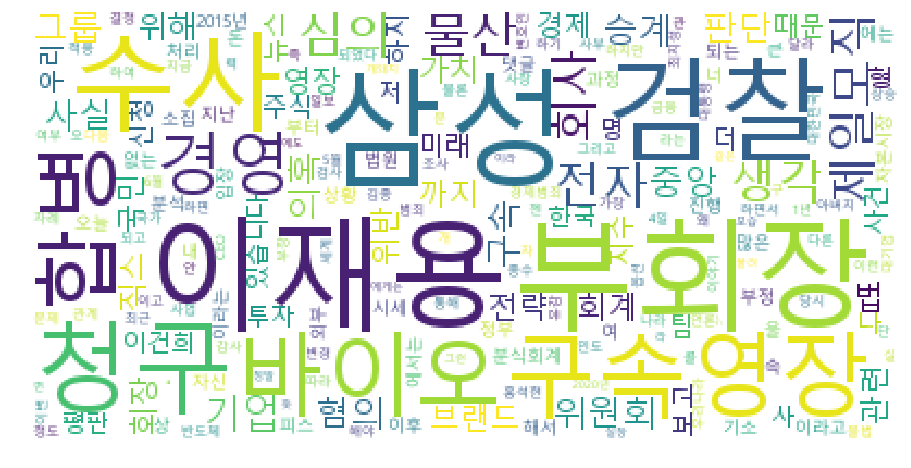

In [38]:
# 워드클라우드를 그려보자
wordcloud = WordCloud(font_path='c:/Windows/Fonts/malgun.ttf',
                      relative_scaling = 0.2,
                      #stopwords=STOPWORDS,
                      background_color='white',
                      ).generate_from_frequencies(todict(data))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()